# 1. KPIs (25 puntos)

### Capacidad: Promedio de productos por envío segmentado por store
Mide cuántos productos se envían en promedio por tienda, mostrando la capacidad operativa y eficiencia en la gestión de órdenes.

### Volumen de envíos: Número promedio de envíos segmentado por country_code
Mide la cantidad promedio de envíos realizados por país. Esta métrica ayuda a identificar qué regiones tienen mayor demanda operativa, lo cual es útil para la planificación logística y la optimización de recursos en diferentes mercados.

### Cost: Ratio de Canceled Orders per Delivered Orders
Indica la proporción de pedidos cancelados frente a los entregados. Un ratio alto sugiere problemas operativos; uno bajo refleja eficiencia y buena gestión.


# 3. Experimento (25 puntos)

In [8]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv(r'C:\Users\Davi\Downloads\FAKE_ORDERS\fake_orders_test.csv')

# Paso 1: Preparación de los datos
# Dividir aleatoriamente los datos en grupos de control (tarifa de €1.9) y prueba (tarifa de €2.1)
np.random.seed(42)  # Asegurar la reproducibilidad
data['group'] = np.random.choice(['control', 'test'], size=len(data))

# Asignar tarifas de entrega basadas en el grupo
data['delivery_fee'] = np.where(data['group'] == 'control', 1.9, 2.1)

# Renombrar 'purchase_total_price' a 'order_value' para consistencia
data['order_value'] = data['purchase_total_price']

# Paso 2: Análisis descriptivo
print("Resumen inicial de los datos:")
print(data.head())
print("\nDistribución de datos por grupo:")
print(data['group'].value_counts())



Resumen inicial de los datos:
   order_id activation_time_local country_code  store_address  \
0  33557880               59:59.0           AR          14200   
1  33512615               58:32.0           TR          28725   
2  33512451               57:56.0           TR          28725   
3  33530892               57:33.0           ES          19777   
4  33557765               57:21.0           AR          34565   

      final_status payment_status  products  products_total  \
0  DeliveredStatus           PAID         1            4.54   
1  DeliveredStatus           PAID         1            3.76   
2  DeliveredStatus           PAID         1            2.86   
3   CanceledStatus           PAID         1           12.95   
4  DeliveredStatus           PAID         2            2.86   

   purchase_total_price    group  delivery_fee  order_value  
0                  8.64  control           1.9         8.64  
1                  3.76     test           2.1         3.76  
2             

In [12]:
# Paso 3: Prueba de hipótesis
# Hipótesis:
# H0: No hay diferencia significativa en los KPIs entre los grupos de control y prueba.
# H1: Existe una diferencia significativa en los KPIs entre los grupos de control y prueba.

# Métricas a calcular: tasa de conversión, valor promedio de pedido (AOV), ingresos por cliente

# Calcular KPIs para cada grupo
kpi_summary = data.groupby('group').agg(
    order_count=('order_id', 'count'),
    total_revenue=('order_value', 'sum'),
    avg_order_value=('order_value', 'mean')
).reset_index()

# Calcular la tasa de conversión en función del número de pedidos únicos
kpi_summary['conversion_rate'] = kpi_summary['order_count'] / len(data['order_id'].unique())

print("\nResumen de KPIs:")
print(kpi_summary)


Resumen de KPIs:
     group  order_count  total_revenue  avg_order_value  conversion_rate
0  control        30270      324128.43        10.707910         0.501159
1     test        30130      322359.79        10.698964         0.498841


In [14]:
# Paso 4: Pruebas estadísticas para la comparación de grupos
# Prueba t para verificar diferencias significativas en el valor promedio de pedido
control_aov = data.loc[data['group'] == 'control', 'order_value']
test_aov = data.loc[data['group'] == 'test', 'order_value']

# Realizar una prueba t de dos muestras
t_stat, p_value = stats.ttest_ind(control_aov, test_aov, equal_var=False)
print(f"\nPrueba t para AOV - estadístico t: {t_stat:.2f}, valor p: {p_value:.4f}")

# Realizar una prueba de Kolmogorov-Smirnov para verificar la similitud de la distribución
ks_stat, ks_p_value = stats.ks_2samp(control_aov, test_aov)
print(f"\nPrueba de Kolmogorov-Smirnov para similitud de distribución - estadístico KS: {ks_stat:.2f}, valor p: {ks_p_value:.4f}")




Prueba t para AOV - estadístico t: 0.10, valor p: 0.9188

Prueba de Kolmogorov-Smirnov para similitud de distribución - estadístico KS: 0.00, valor p: 0.9700


In [16]:
# Paso 5: Cálculo del tamaño de muestra para la duración del experimento
# Definir parámetros para el cálculo del tamaño de muestra
alpha = 0.05  # nivel de significancia
power = 0.8  # potencia deseada
effect_size = (control_aov.mean() - test_aov.mean()) / control_aov.std()  # tamaño del efecto estandarizado

# Calcular el tamaño de muestra
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
print(f"\nTamaño de muestra estimado requerido por grupo: {int(sample_size):,}")




Tamaño de muestra estimado requerido por grupo: 23,049,791


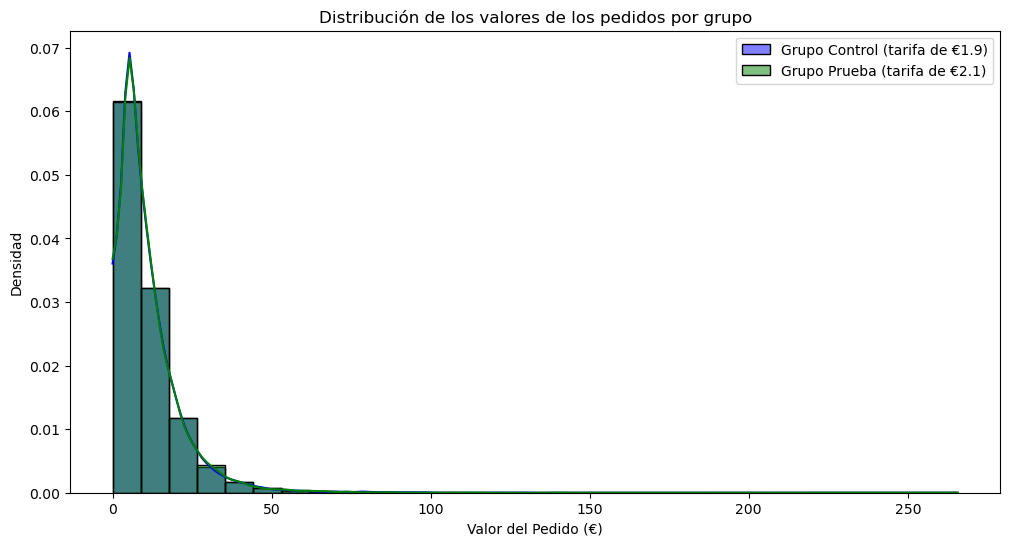

In [18]:
# Paso 6: Visualización de los datos
# Graficar las distribuciones de los valores de los pedidos para los grupos de control y prueba
plt.figure(figsize=(12, 6))
sns.histplot(control_aov, label='Grupo Control (tarifa de €1.9)', color='blue', kde=True, stat="density", bins=30)
sns.histplot(test_aov, label='Grupo Prueba (tarifa de €2.1)', color='green', kde=True, stat="density", bins=30)
plt.title('Distribución de los valores de los pedidos por grupo')
plt.xlabel('Valor del Pedido (€)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [20]:
# Paso 7: Recomendaciones basadas en los resultados
if p_value < 0.05:
    print("\nRecomendación: Los resultados son estadísticamente significativos. Considera las implicaciones de aumentar la tarifa si no afecta negativamente la tasa de conversión o la retención de clientes.")
else:
    print("\nRecomendación: Los resultados no son estadísticamente significativos. Puede ser necesario realizar más pruebas o análisis antes de tomar una decisión.")


Recomendación: Los resultados no son estadísticamente significativos. Puede ser necesario realizar más pruebas o análisis antes de tomar una decisión.


C:\Users\Davi\AppData\Local\Temp\ipykernel_18588\3516042907.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='order_value', data=data, palette=['blue', 'green'], whis=1.5)


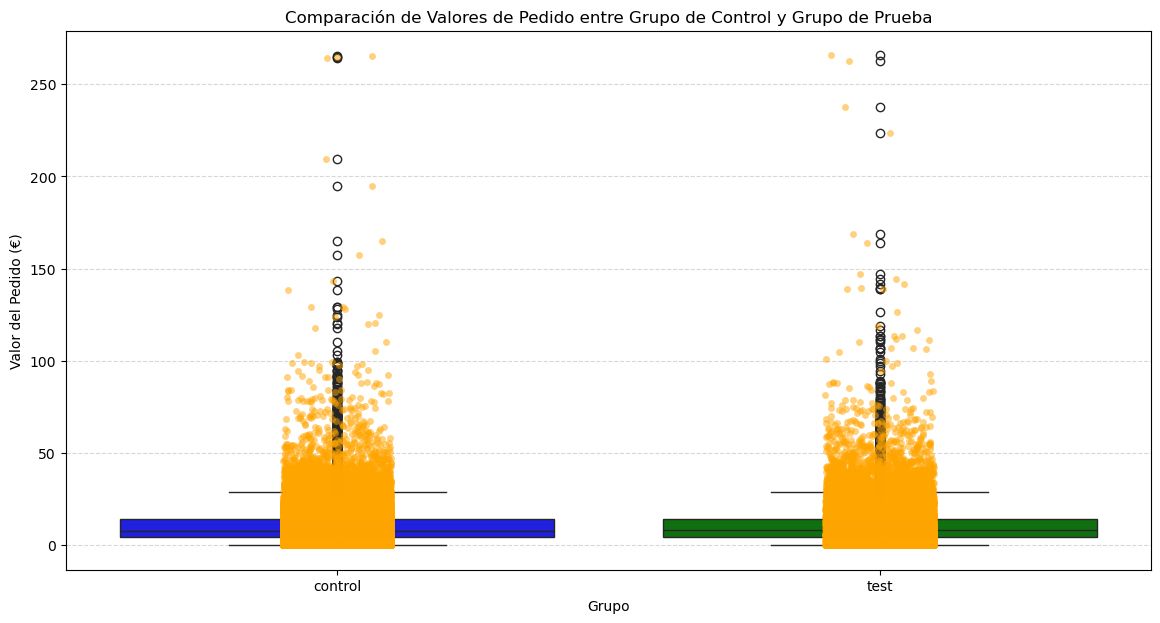

In [22]:
# Paso 8: Visualización adicional para comparar los resultados
plt.figure(figsize=(14, 7))

# Boxplot para mostrar la distribución general y los percentiles de los datos
sns.boxplot(x='group', y='order_value', data=data, palette=['blue', 'green'], whis=1.5)

# Stripplot para mostrar todos los puntos individuales, resaltando la dispersión
sns.stripplot(x='group', y='order_value', data=data, color='orange', jitter=True, alpha=0.5)

plt.title('Comparación de Valores de Pedido entre Grupo de Control y Grupo de Prueba')
plt.xlabel('Grupo')
plt.ylabel('Valor del Pedido (€)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
